## Predictive Analysis of Cancer Data Using a Machine Learning Classification Model

### Introduction

Cancer tumors are mainly of two types, Benign and Malignant. While none of these types are 'good', both of these function in different ways. Benign cancer does not invade and spread like Malignant cancer, and is generally less painful, but still lethal. Early detection of cancer and its type is essential for the treatment of patients, which calls for the question that we want to address: Is a new observation Benign or Malignant based on the mean statistics of the observation as our predictors?

This classification model trains on a cancer dataset (with 567 observations) which contains statistics of various cancer cells and classifies them as either Benign (B) or Malignant (M). In this project, we will analyse the dataset, use the $K$-nearest neighbors machine learning classification algorithm make predictions, and then assess the accuracy of our predictive analysis. 

In [ ]:
library(tidyverse)
library(repr)
library(recipes)
library(cowplot)
library(GGally)
library(tidymodels)
install.packages('kknn')
library(kknn)
library(ggplot2)

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



### Preliminary Exploratory Data Analysis

We will first read the dataset from the web into R, and then clean our data. Here, we notice that the class column has 0's and 1's. The 1's mean that the observation is not a significant heart disease, and 0's mean it is a significant heart disease.

In [ ]:
# reading the data from the web and adding a factor output variable called 'class'
# also removing columns id and diagnosis because we do not require them anymore
cancer_data <- read_csv('https://raw.githubusercontent.com/NISH-Original/Heart-Attack-Analysis/main/cancer_data.csv') |>
                    mutate(class = as.factor(diagnosis)) |>
                    select(radius_mean:class)

print('Table 1')
head(cancer_data, 10)

New names:
• `` -> `...33`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 568 Columns: 33
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): diagnosis
dbl (31): id, radius_mean, texture_mean, perimeter_mean, area_mean, smoothne...
lgl  (1): ...33

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1"


radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,⋯,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,...33,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>
17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,⋯,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NA,M
20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,⋯,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NA,M
19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,⋯,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NA,M
11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,⋯,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NA,M
20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,⋯,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NA,M
12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,⋯,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NA,M
18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,⋯,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NA,M
13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,⋯,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NA,M
13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,⋯,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NA,M


We now have to scale all the potential predictor variables so that the prediction is not influenced by the different scales of all the predictors, thus avoiding inaccurate predictions. Also, we will only use the 'mean' statistics in the dataset for prediction.

In [ ]:
required_cols <- c('radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'class')

cancer_scaled <- cancer_data |>
                    select(all_of(required_cols)) |>
                    mutate(across(where(is.numeric), scale))

head(cancer_scaled)

radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,class
"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
1.0951132,-2.0702630,1.2681916,0.9818460,1.5737125,3.2795417,2.6491483,2.5293505,2.2134838912,2.2514169,M
1.8286958,-0.3513251,1.6846895,1.9060324,-0.8381537,-0.4888074,-0.0257915,0.5457278,-0.0000513617,-0.8683511,M
1.5784816,0.4581342,1.5651010,1.5562634,0.9431593,1.0502760,1.3606102,2.0342828,0.9371456070,-0.3984042,M
-0.7729634,0.2557694,-0.5965646,-0.7667148,3.3005686,3.3988652,1.9126616,1.4489684,2.8625930758,4.9026535,M
1.7490822,-1.1491542,1.7754118,1.8235666,0.2767791,0.5369957,1.3681382,1.4257621,-0.0109914041,-0.5626025,M
-0.4800990,-0.8328138,-0.3907899,-0.5079426,2.2472580,1.2415724,0.8637640,0.8221406,1.0027858616,1.8862172,M


Now we can continue with splitting 75% of our data into training and and 25% testing.

In [ ]:
set.seed(100)

cancer_split <- cancer_scaled |>
                    initial_split(prop=3/4, strata=class)
cancer_training <- training(cancer_split)
cancer_testing <- testing(cancer_split)

Now, we can search for any missing data in our training set

In [ ]:
missing_data <- cancer_training |>
                    map_df(~sum(is.na(.)))

print("Table 4")
pivot_longer(missing_data, 
            cols = everything(), 
            names_to = 'column',
            values_to = 'missing data')

[1] "Table 4"


column,missing data
<chr>,<int>
radius_mean,0
texture_mean,0
perimeter_mean,0
area_mean,0
smoothness_mean,0
compactness_mean,0
concavity_mean,0
concave points_mean,0
symmetry_mean,0


Fortunately, we can see that we do not have empty data to deal with, so we can proceed to find out how many observations exist for each class in our training set.

In [ ]:
class_counts <- cancer_training |>
                    group_by(class) |>
                    summarize(count = n())

print("Table 5")
class_counts

[1] "Table 5"


class,count
<fct>,<int>
B,267
M,159


The amount of observations with Benign and Malignant classes are fairly balanced, thus upsampling would not be required. Now, we find the means of the variables based on our two classes

In [ ]:
means <- cancer_training |>
            group_by(class) |>
            summarize_at(vars(everything()), mean)

print("Table 6")
means

[1] "Table 6"


class,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B,-0.5952172,-0.2753065,-0.6056353,-0.5709076,-0.2446162,-0.4883627,-0.5831508,-0.6282829,-0.2077619,0.01471583
M,0.9455426,0.5714076,0.9650783,0.9179354,0.4269456,0.8143724,0.8830408,0.9854247,0.4603708,0.01461990


We see that the means are very different for classes B and M which helps in differentiating them from each other. We will now plot them in pairs to better visualise the correlations.

NULL

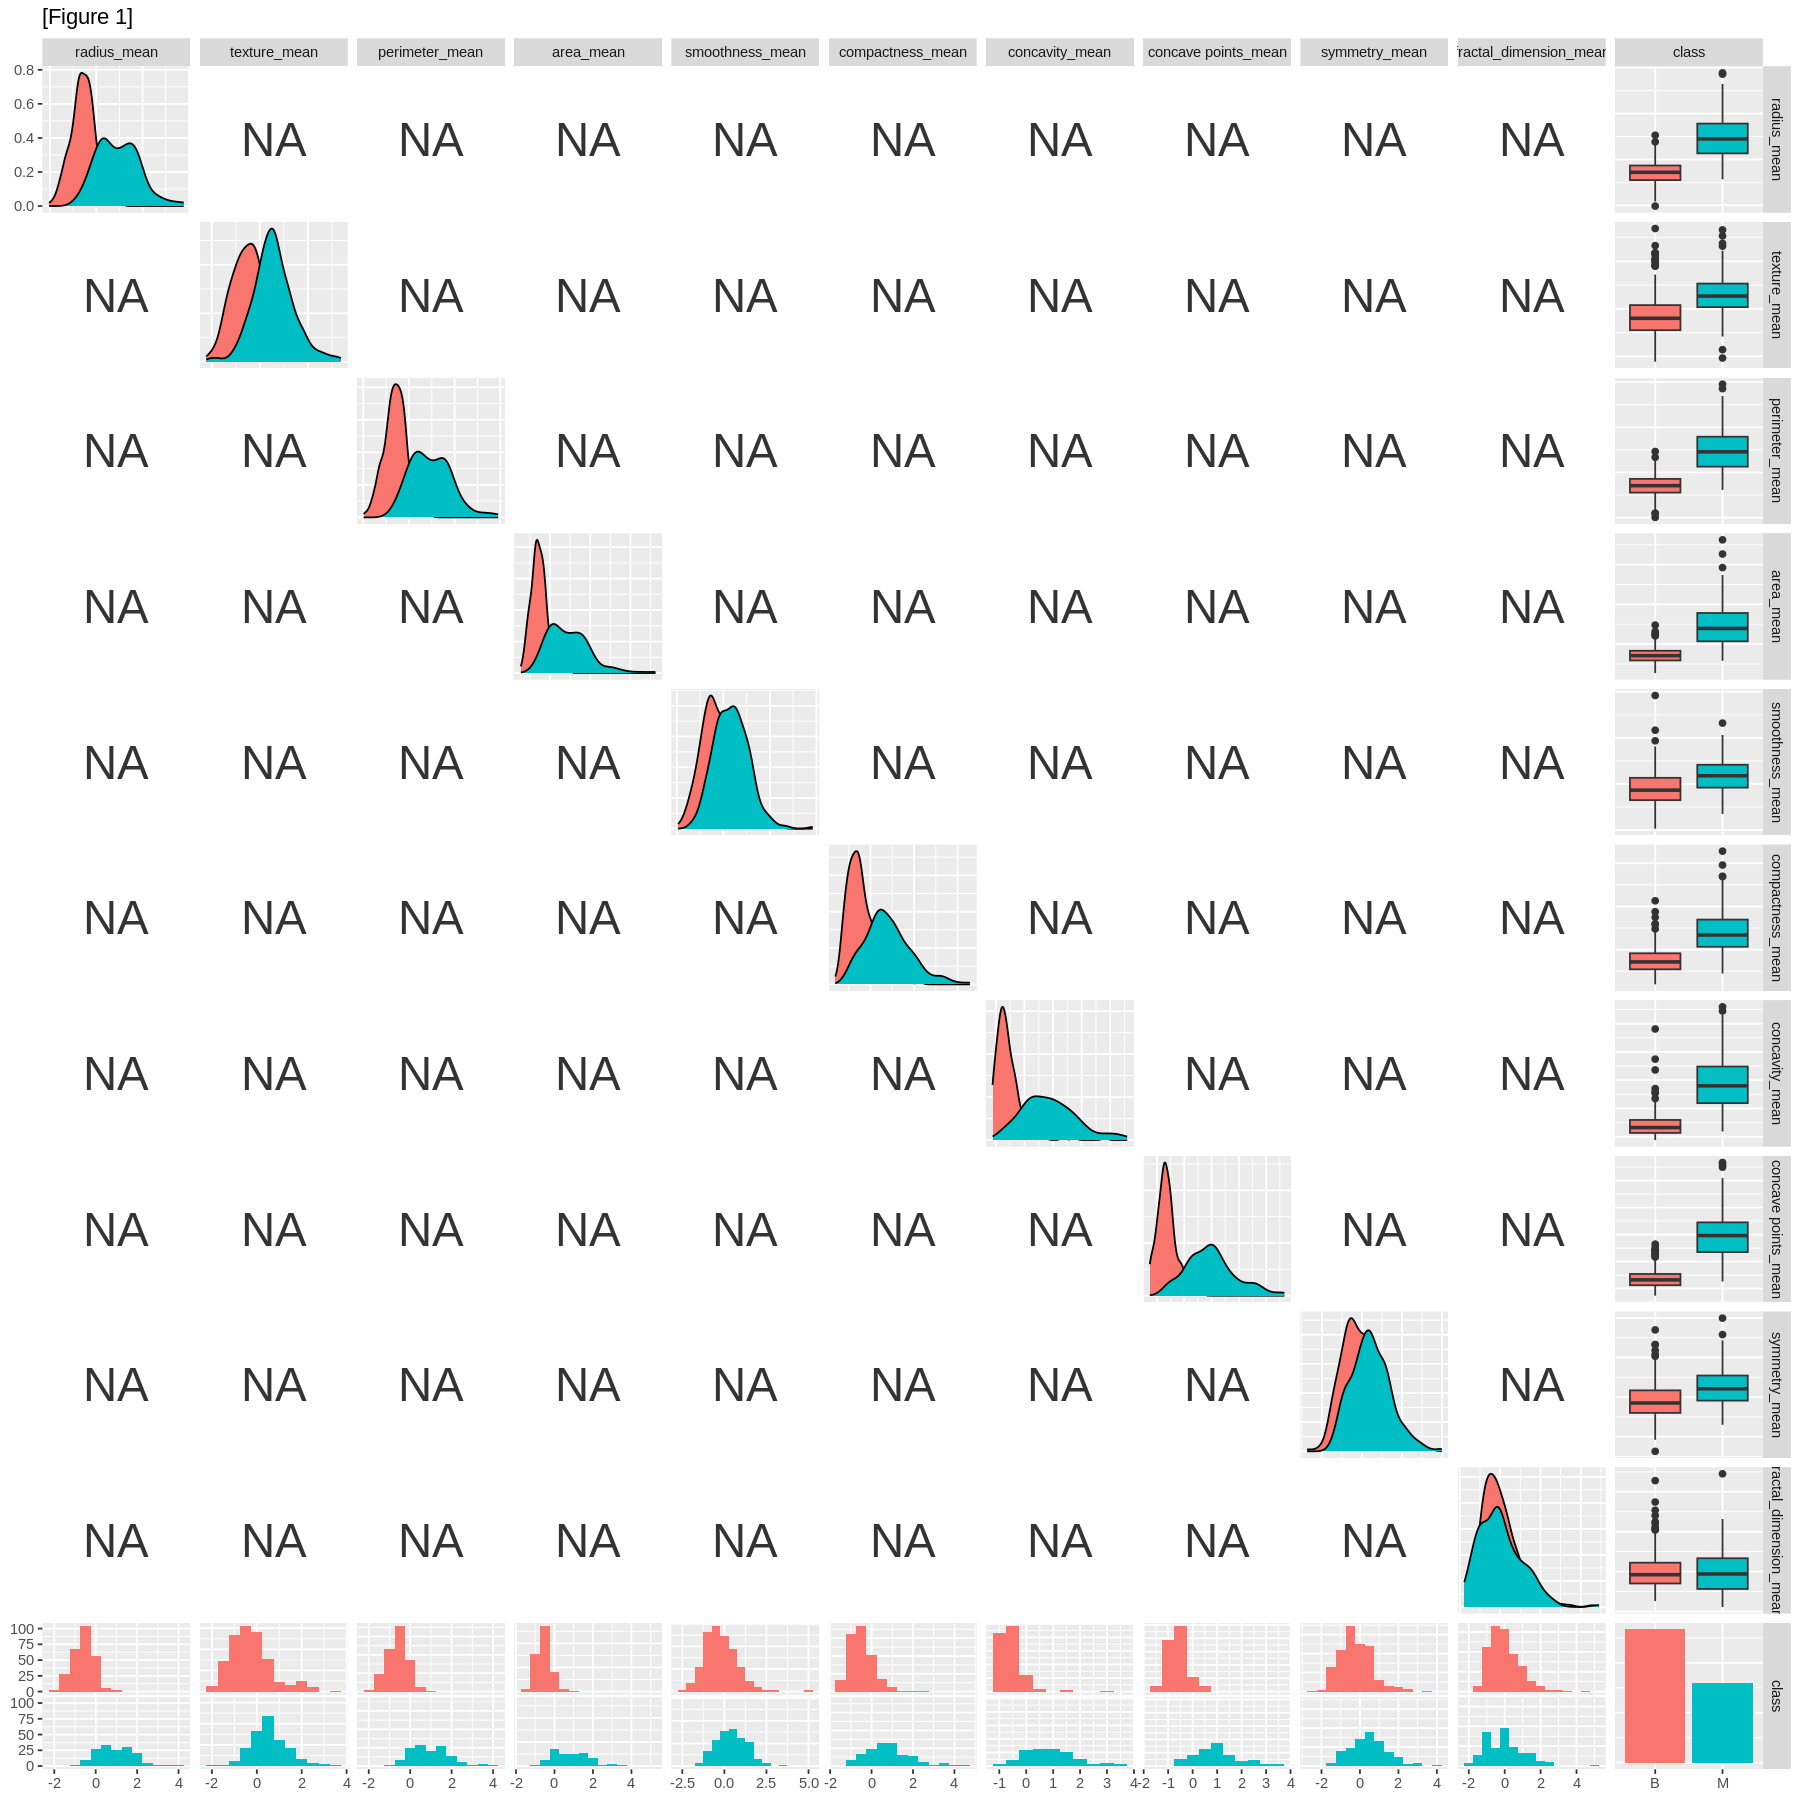

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 15)

pairs_plot <- cancer_training |>
                ggpairs(aes(color=class), 
                        lower=list(combo=wrap("facethist", binwidth=0.5))) +
                ggtitle("[Figure 1]")
                labs(color=class) +
                theme(text=element_text(size=30))
 
pairs_plot

We can now visualize that the overlap between the classes for each predictor variable is relatively low, which is ideal for classification. Thus, we can go ahead with these predictor variables.

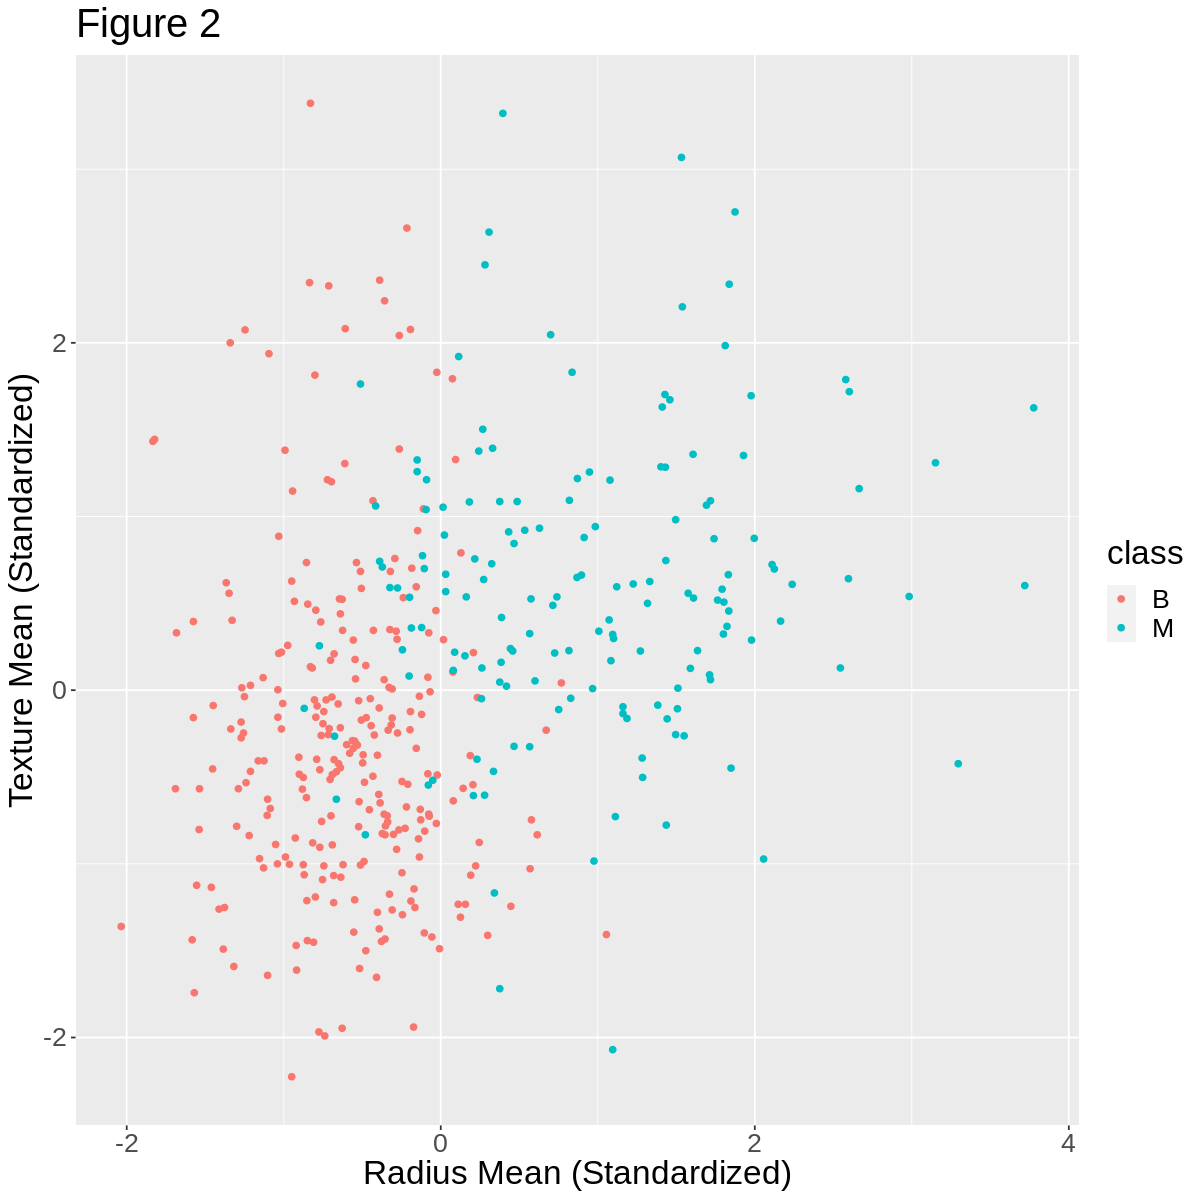

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

cancer_viz_1 <- cancer_training |>
                    ggplot(aes(x=radius_mean, y=texture_mean, color=class)) +
                    ggtitle("Figure 2") +
                    geom_point() +
                    xlab('Radius Mean (Standardized)') +
                    ylab('Texture Mean (Standardized)') +
                    theme(text = element_text(size = 20))

cancer_viz_1

Above, we see a general trend that the observation is Benign for lower values of radius and texture mean, while Malignant for the higher values. This gives us insight into the varying nature of both the classes and how they can be differentiated using our classification model. 

### Training The Model

Now, we use $K$-nearest neighbors classification and cross validation of 5 folds in order to train our data. Firstly, we will tune the number of neighbors to find the ideal value for $K$. We will thus test for all values of $K$ from 1 to 20 in steps of 2.

In [ ]:
cancer_recipe <- recipe(class ~ ., data=cancer_training) |>
                    step_scale(all_predictors()) |>  
                    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

cancer_vfold <- vfold_cv(cancer_training, v=5, strata=class)

gridvals <- tibble(neighbors=seq(from=1, to=20, by=1))

cancer_workflow <- workflow() |>
                       add_recipe(cancer_recipe) |>
                       add_model(knn_tune) |>
                       tune_grid(resamples=cancer_vfold, grid=gridvals) |>
                       collect_metrics()

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we collect the accuracy metrics and then plot them against the $K$ values in order to find the most suitable value for our model.

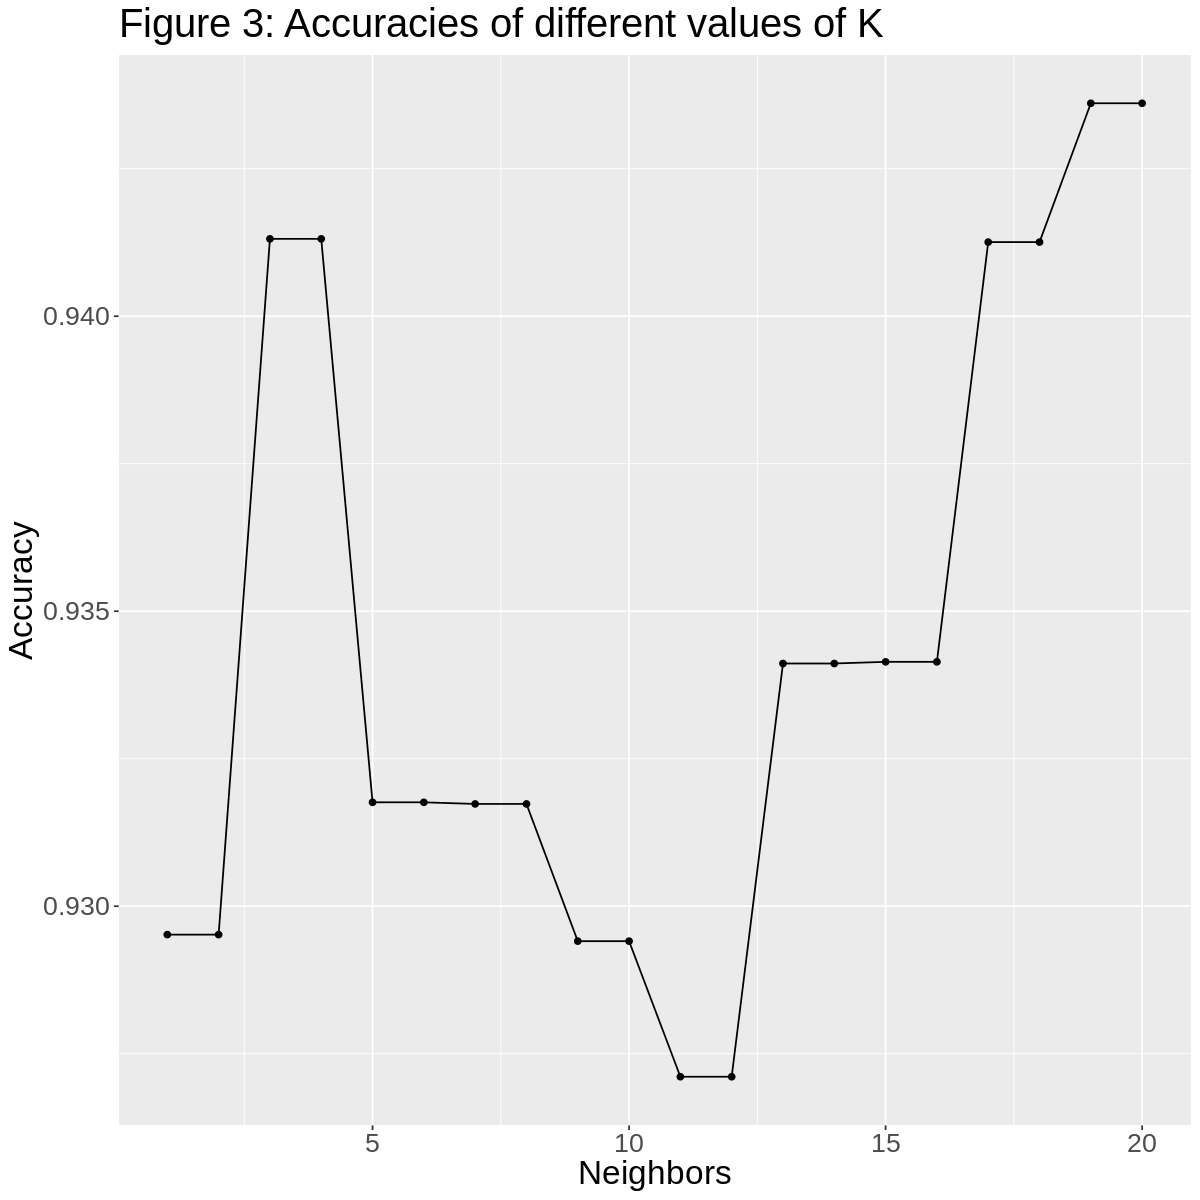

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 10)

accuracies <- cancer_workflow |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean)

accuracy_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
                     geom_line() +
                     geom_point() +
                     labs(x = "Neighbors", y = "Accuracy", 
                          title = "Figure 3: Accuracies of different values of K") +
                     theme(text = element_text(size = 20))

accuracy_plot

Here, we see that the accuracy is the greatest for $K = 11$. Thus, we can go ahead and train the model with 11 neighbors.

In [ ]:
knn_tune_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
                set_engine("kknn") |>
                set_mode("classification")

cancer_fit <- workflow() |>
                add_recipe(cancer_recipe) |>
                add_model(knn_tune_2) |>
                fit(data = cancer_training)

Now, we can make predictions on the testing data.

### Making Predictions

In [ ]:
cancer_predictions <- predict(cancer_fit , cancer_testing) |>
       bind_cols(cancer_testing)


print("Table 7")
head(cancer_predictions)

[1] "Table 7"


.pred_class,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,class
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<fct>
M,1.8286958,-0.3513251,1.6846895,1.906032,-0.8381537,-0.48880745,-0.0257915,0.5457278,-0.0000513617,-0.8683511,M
M,1.5784816,0.4581342,1.5651010,1.556263,0.9431593,1.05027604,1.3606102,2.0342828,0.9371456070,-0.3984042,M
M,1.7490822,-1.1491542,1.7754118,1.823567,0.2767791,0.53699567,1.3681382,1.4257621,-0.0109914041,-0.5626025,M
M,1.1690401,0.1627281,1.1362318,1.092748,-0.1294978,0.08621808,0.2979114,0.6444835,-0.0656916163,-0.7621884,M
M,-0.4772557,1.1070972,-0.3330575,-0.511355,1.5880433,2.55981276,1.7357542,0.9392034,0.7949250553,2.7779839,M
M,1.6126017,0.6674771,1.5651010,1.718351,0.1341881,-0.03310540,0.7395524,1.1854480,-0.8387879485,-1.2533679,M


### Calculating Accuracies

In [ ]:
cancer_accuracy <- cancer_predictions |>
                     metrics(truth = class, estimate = .pred_class) 

print("Table 8")
cancer_accuracy

[1] "Table 8"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9577465
kap,binary,0.9103724


We see that we have an accuracy of approximately 95.7%, which is very good for a classification model. We can also have a look at the confusion matrix.

In [ ]:
conf_mat <- cancer_predictions |> 
                conf_mat(truth = class, estimate = .pred_class)

print("Table 9")
conf_mat

[1] "Table 9"


          Truth
Prediction  B  M
         B 85  2
         M  4 51

### Visualising the Accuracy of the Model

We can now try and visualize the accuracy of our predictions by plotting some predictors of the testing data and their predictions to see how similar they are to each other. For this instance, let's just see the comparisons between the plots of radius mean versus the texture mean of the observations.

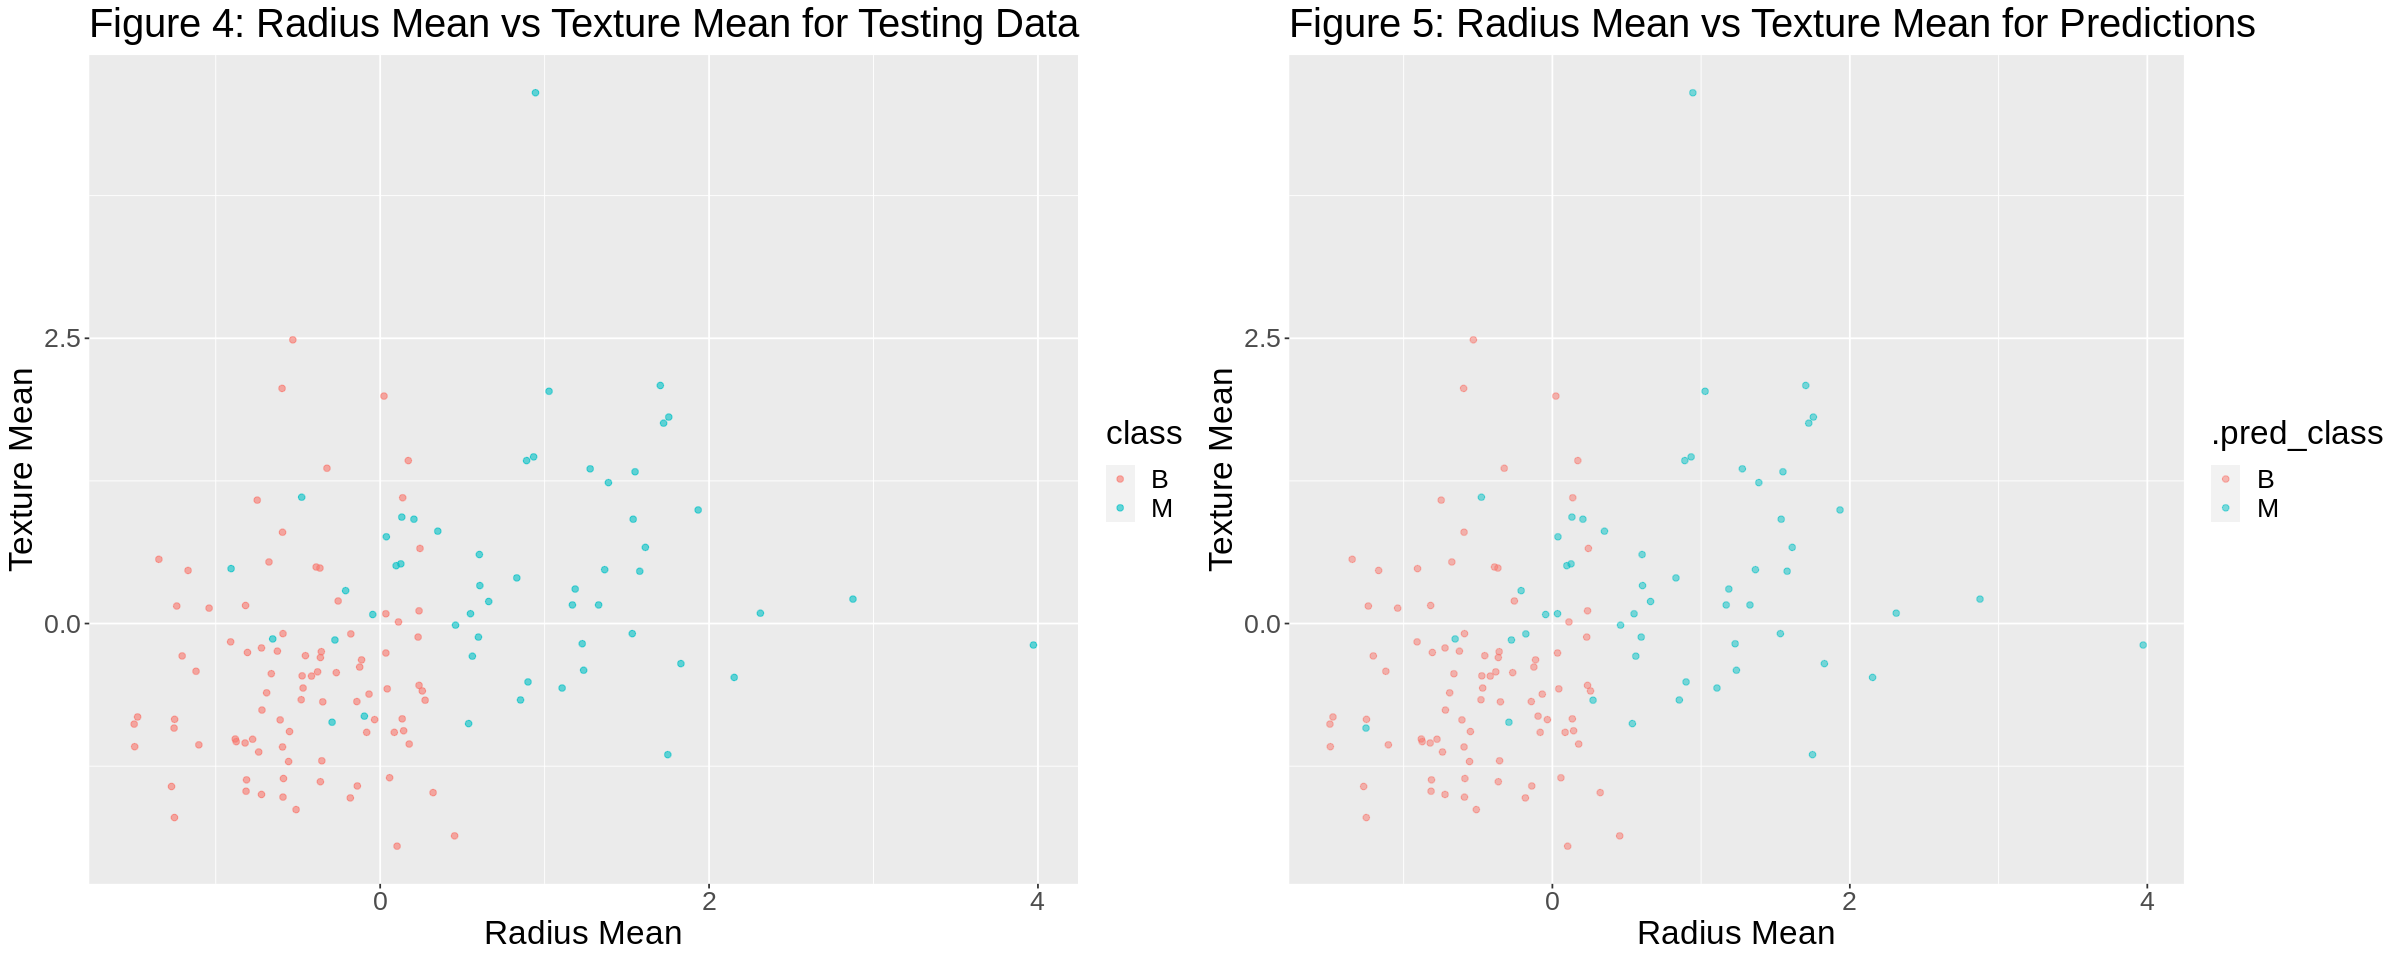

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 8)

accuracy_test <- ggplot(cancer_testing, aes(x=radius_mean, y=texture_mean, color=class)) + 
                                geom_point(alpha=0.6) + 
                                ggtitle('Figure 4: Radius Mean vs Texture Mean for Testing Data') +
                                labs(x= 'Radius Mean', y= 'Texture Mean') +
                                theme(text=element_text(size=20))

accuracy_pred <- ggplot(cancer_predictions, aes(x=radius_mean, y=texture_mean, color=.pred_class)) + 
                                geom_point(alpha = 0.5) + 
                                ggtitle('Figure 5: Radius Mean vs Texture Mean for Predictions') +
                                labs(x= 'Radius Mean', y= 'Texture Mean') +
                                theme(text=element_text(size=20))

plot_grid(accuracy_test, accuracy_pred)

From the visualizations above, we see that the prediction graphs look very similar to the testing data which shows that we have a pretty accurate model for predicting benign or malignant cancer cells from the data.

### Outcomes and Future Discussions

Our classification model finally turned out to be approximately 95.7% accurate. This is a very good score, and is probably a direct result of us using various tuning methods such as cross-validation, comparing various $K$ values and finding the best one, and scaling our data so that the results are not biased. 

We can still make improvements to this by using various other machine learning algorithms as it is of utmost importance that we can correctly predict the type of cancer cells, as it affects human life itself. In the future, we can make further improvements by predicting the intensity of the cancer based on the statistics of the cells, or even make models used to predict the presence of other diseases. This technology is instrumental in the healthcare sector for the timely detection and cure of various diseases.

### Resources

- Dataset: https://www.kaggle.com/datasets/erdemtaha/cancer-data
- Information: Patel A. Benign vs Malignant Tumors. JAMA Oncol. 2020;6(9):1488. doi:10.1001/jamaoncol.2020.2592